<a href="https://colab.research.google.com/github/irynagorbenko/data-science/blob/opi-radiomics/All_features_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DLA WSZYSTKICH: podzielić na PZ i TZ. Analizy robimy osobno dla różnych stref - 4 regresji

I. rozroznienie rak/nie rak

1. TBx_SBx_state =1, 0 (N/A odrzucamy) - kliniczny
2. podzielić na PZ i TZ - radiologiczny
3. regresja wg cech radiomicznych

nr of study = 


II. rozruzniamy isup (1 -5) dla rakowych pacjentow (isup_group)

1. TBx_SBx_state =1
2. no_of_possitive = 1
3. podzielić na PZ i TZ - radiologiczny
4. regresja wg cech radiomicznych / klasyfikator (lasy losowe)

nr of study = 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

In [2]:
# Read data from CSV
clinDF = pd.read_csv('/content/AI4A4_PCa_clinical.csv')
srDF = pd.read_csv('/content/AI4AR_PCa_radiological.csv')
t2wDF = pd.read_csv('/content/radiomics_t2w.csv')
adcDF = pd.read_csv('/content/radiomics_adc.csv')

In [3]:
print(clinDF.shape, t2wDF.shape, srDF.shape, adcDF.shape)

(503, 47) (1046, 112) (1464, 21) (1036, 112)


In [4]:
clinDF.columns = clinDF.columns.str.replace(' ', '')

In [5]:
# Get studies where TBx_SBx_state =1, 0 (true positive, true negative cancer)

clinDF = clinDF[clinDF['TBx_SBx_state'].notna()]
clinDF.shape

# Get studies where TBx_SBx_state = 0
clinDF0 = clinDF[clinDF['TBx_SBx_state']==0]

# Get studies where TBx_SBx_state = 1
clinDF1 = clinDF[clinDF['TBx_SBx_state']==1]
print(clinDF0.shape, clinDF1.shape)

(196, 47) (183, 47)


In [6]:
# Divide to PZ and TZ lesions

# PZ
srDF[['patient_id', 'lesion_originating']].head(10)
srDF_PZ = srDF[srDF['lesion_originating'] == 'PZ']

# TZ
srDF_TZ = srDF[srDF['lesion_originating'] == 'TZ']

print(srDF_PZ.shape, srDF_TZ.shape)

(699, 21) (765, 21)


In [7]:
# Prepare studies in PZ

id_PZ = srDF_PZ[['patient_id']].drop_duplicates()
id_PZ.shape

# Studies where TBx_SBx_state = 1 (aimed biopsy is positive, systematic is not important) - true positive, cancer
clinDF_PZ1 = clinDF1[clinDF1['patient_id'].isin(id_PZ['patient_id'])]

# Studies where TBx_SBx_state = 0 (aimed biopsy is negative, systematic is negative) - true negative, healthy
clinDF_PZ0 = clinDF0[clinDF0['patient_id'].isin(id_PZ['patient_id'])]

# Studies where TBx_SBx_state = 0, 1
clinDF_PZ = clinDF[clinDF['patient_id'].isin(id_PZ['patient_id'])]
print(clinDF_PZ0.shape, clinDF_PZ1.shape, clinDF_PZ.shape)

(50, 47) (133, 47) (183, 47)


In [8]:
# Prepare studies in TZ

id_TZ = srDF_TZ[['patient_id']].drop_duplicates()
id_TZ.shape

# Studies where TBx_SBx_state =1 (aimed biopsy is positive, systematic is not important) - true positive, cancer
clinDF_TZ1 = clinDF1[clinDF1['patient_id'].isin(id_TZ['patient_id'])]

# Studies where TBx_SBx_state =0 (aimed biopsy is negative, systematic is negative) - true negative, healthy
clinDF_TZ0 = clinDF0[clinDF0['patient_id'].isin(id_TZ['patient_id'])]

# Studies where TBx_SBx_state = 0, 1
clinDF_TZ = clinDF[clinDF['patient_id'].isin(id_TZ['patient_id'])]
print(clinDF_TZ0.shape, clinDF_TZ1.shape, clinDF_TZ.shape)

(101, 47) (107, 47) (208, 47)


# **Statistic analysis in PZ**

In [ ]:
t2wDF.head(10)

In [9]:
# Mark studies as healthy and with cancer
adcDF_PZ0 = adcDF[adcDF['patient_id'].isin(clinDF_PZ0['patient_id'])]
adcDF_PZ1 = adcDF[adcDF['patient_id'].isin(clinDF_PZ1['patient_id'])]
t2wDF_PZ0 = t2wDF[t2wDF['patient_id'].isin(clinDF_PZ0['patient_id'])]
t2wDF_PZ1 = t2wDF[t2wDF['patient_id'].isin(clinDF_PZ1['patient_id'])]

adcDF_PZ0.insert(2, 'is_cancer', 0)
adcDF_PZ1.insert(2, 'is_cancer', 1)
t2wDF_PZ0.insert(2, 'is_cancer', 0)
t2wDF_PZ1.insert(2, 'is_cancer', 1)

# Merge dataframes
adcDF_PZ0 = adcDF_PZ0.reset_index();
adcDF_PZ1 = adcDF_PZ1.reset_index();
t2wDF_PZ0 = t2wDF_PZ0.reset_index();
t2wDF_PZ1 = t2wDF_PZ1.reset_index();

adcDF_PZ = pd.concat([adcDF_PZ0, adcDF_PZ1], ignore_index=True, sort=False)
t2wDF_PZ = pd.concat([t2wDF_PZ0, t2wDF_PZ1], ignore_index=True, sort=False)

print('ADC: ', adcDF_PZ0.shape, adcDF_PZ1.shape, adcDF_PZ.shape)
print('T2W: ', t2wDF_PZ0.shape, t2wDF_PZ1.shape, t2wDF_PZ.shape)

ADC:  (87, 114) (454, 114) (541, 114)
T2W:  (89, 114) (453, 114) (542, 114)


In [ ]:
# Remove unnecessary columns
list(adcDF_PZ.columns)

# Compactness1 and Compactness2, as well as SphericalDisproportion from Shape features were excluded because they are directly correlated to Sphericity (based on 
# the definition of the feature, as discussed in the documentation of pyradiomics). Flatness and LeastAxis from Shape features were excluded because some tumor ROIs 
# were only defined on one slice and these features do not yield useful values for non-3D objects. SumAverage was excluded because it is directly correlated with JointAverage. 
# Homogeneity1 and Homogeneity2 were disabled because they are directly correlated to InverseDifferenceMoment. (Michael Schwier et al. "Repeatability of Multiparametric Prostate MRI Radiomics Features")

adcDF_PZ = adcDF_PZ.drop(['index', 'mask_path', 'data_path', 'original_shape_Flatness', 'original_shape_LeastAxisLength', 'original_glcm_SumAverage', ], axis=1)
adcDF_PZ

t2wDF_PZ = t2wDF_PZ.drop(['index', 'mask_path', 'data_path', 'original_shape_Flatness', 'original_shape_LeastAxisLength', 'original_glcm_SumAverage', ], axis=1)
t2wDF_PZ

In [ ]:
# DEBUG 
adcDF_PZ.columns[adcDF_PZ.columns.str.contains('original_')]

In [11]:
# Remane columns according to modality
adcDF_PZ.columns = ['adc_' + col.lower() for col in adcDF_PZ.columns]
t2wDF_PZ.columns = ['t2w_' + col.lower() for col in t2wDF_PZ.columns]

In [ ]:
adcDF_PZ.rename(columns = {'adc_patient_id':'patient_id', 'adc_lesion_id':'lesion_id', 'adc_is_cancer':'is_cancer', 'adc_radiologist_id':'radiologist_id'}, inplace = True)
adcDF_PZ

t2wDF_PZ.rename(columns = {'t2w_patient_id':'patient_id', 't2w_lesion_id':'lesion_id', 't2w_is_cancer':'is_cancer', 't2w_radiologist_id':'radiologist_id'}, inplace = True)
t2wDF_PZ

In [ ]:
# Menge ADC and T2W dataframes
df = pd.merge(t2wDF_PZ, adcDF_PZ, on=['patient_id', 'lesion_id', 'radiologist_id', 'is_cancer'])
df.isnull().sum()

In [ ]:
# DEBUG
df.to_csv('temp.csv') 
files.download('temp.csv')

In [ ]:
# Sort dataframe
df_sorted = df.sort_values(by=['patient_id', 'lesion_id', 'radiologist_id'])
df_sorted = df_sorted.reset_index()
df_sorted = df_sorted.drop(['index'], axis=1)
df_sorted

In [ ]:
# DEBUG

temp = df.sort_values(by=['patient_id', 'lesion_id', 'radiologist_id'])
temp.to_csv('t2w_adc_features_sorted.csv') 
files.download('t2w_adc_features_sorted.csv')

In [266]:
# Get basic info

pd.set_option('display.float_format', lambda x: f'{x:.2f}')
df_sorted.describe().T
df_sorted.groupby('is_cancer').size()

is_cancer
0     86
1    450
dtype: int64

In [ ]:
# Correlation check

corrDF = df_sorted.copy().drop(['index', 'patient_id', 'lesion_id', 'is_cancer', 'radiologist_id'], axis=1)
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=corrDF.shape[1]**2):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(corrDF))
corrResult = get_top_abs_correlations(corrDF)

In [ ]:
# DEBUG

corrResult.to_csv('features_correlation.csv') 
files.download('features_correlation.csv')

## **Normality tests**

In [273]:
df = df_sorted.copy()
df = df.drop(['patient_id', 'lesion_id', 'is_cancer', 'radiologist_id'], axis=1)
df.shape

(536, 208)

In [280]:
df.loc[1]

t2w_original_shape_elongation                   0.66
t2w_original_shape_majoraxislength             15.18
t2w_original_shape_maximum2ddiametercolumn     11.13
t2w_original_shape_maximum2ddiameterrow        13.36
t2w_original_shape_maximum2ddiameterslice      15.50
                                               ...  
adc_original_ngtdm_busyness                     0.04
adc_original_ngtdm_coarseness                   0.08
adc_original_ngtdm_complexity                2189.88
adc_original_ngtdm_contrast                     1.10
adc_original_ngtdm_strength                    28.25
Name: 1, Length: 208, dtype: float64

In [ ]:
# Shapiro-Wilk Test

import math
import numpy as np
from scipy.stats import shapiro 

df_shapiro = [shapiro(col) for col in df.iteritems()]
df_shapiro
# According to Shapiro-Wilk test results are not normally distributed
#health_shapiro = shapiro(c1[['psa_result_PZ0']])

In [ ]:
df.iloc[:, lambda df: [0, (df.shape[1]-1)]]

In [286]:
 df.shape[1]

208

In [ ]:
# Kolmogorov-Smirnov Test

import math
import numpy as np
from scipy.stats import kstest

#perform Kolmogorov-Smirnov test for normality
health_kstest = kstest(c1[['psa_result_PZ0']], 'norm')
cancer_kstest = kstest(c2[['psa_result_PZ1']], 'norm')

# According to Shapiro-Wilk test results are not normally distributed
health_kstest

# **Logistic regression in PZ**

In [17]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [19]:
# Data exploration
df_sorted['is_cancer'].value_counts()

1    450
0     86
Name: is_cancer, dtype: int64

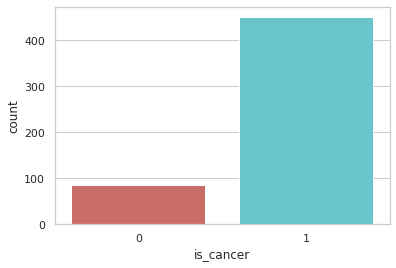

In [20]:
sns.countplot(x='is_cancer', data=df_sorted, palette='hls')
plt.show()
# plt.savefig('count_iscancer_plot')

## **Boxplots - firstorder features for healthy patients**

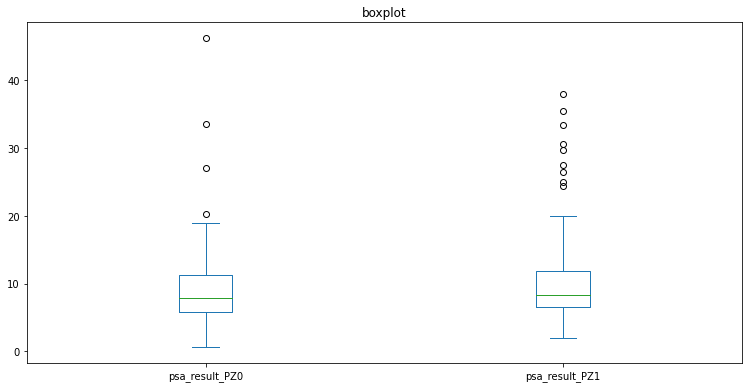

In [ ]:
# Set the figure size
plt.rcParams["figure.figsize"] = [10.50, 5.50]
plt.rcParams["figure.autolayout"] = True

# Plot the dataframe
ax = df[['psa_result_PZ0', 'psa_result_PZ1']].plot(kind='box', title='boxplot')

# Display the plot
plt.show()

## **Normality tests - PSA**

If the p-value of the test is greater than α = .05, then the data is assumed to be normally distributed.

In [ ]:
# Shapiro-Wilk Test

import math
import numpy as np
from scipy.stats import shapiro 

health_shapiro = shapiro(c1[['psa_result_PZ0']])
cancer_shapiro = shapiro(c2[['psa_result_PZ1']])
# According to Shapiro-Wilk test results are not normally distributed

In [ ]:
# Kolmogorov-Smirnov Test

import math
import numpy as np
from scipy.stats import kstest

#perform Kolmogorov-Smirnov test for normality
health_kstest = kstest(c1[['psa_result_PZ0']], 'norm')
cancer_kstest = kstest(c2[['psa_result_PZ1']], 'norm')

# According to Shapiro-Wilk test results are not normally distributed
health_kstest

## **Outliers detection - PSA**

**IQR (Inter Quartile Range)**

IQR = Quartile3 – Quartile1

upper = Q3 +1.5*IQR
lower = Q1 – 1.5*IQR

To define the outlier base value is defined above and below datasets normal range namely Upper and Lower bounds, define the upper and the lower bound

In [ ]:
stats = df.describe()[['psa_result_PZ0', 'psa_result_PZ1']]
stats

In [ ]:
stats.loc['count']

In [ ]:
clinDF_PZ0[['psa_result']] = clinDF_PZ0[['psa_result']].astype('float')

#Changing the outlier markers
red_circle = dict(markerfacecolor='red', marker='o')
mean_shape = dict(markerfacecolor='green', marker='D', markeredgecolor='green')
plt.boxplot(x = clinDF_PZ0[['psa_result']], vert = True, flierprops=red_circle, showmeans=True, meanprops=mean_shape);

In [ ]:
clinDF_PZ = clinDF[clinDF['patient_id'].isin(id_PZ['patient_id'])]
clinDF_PZ.shape

cancer = clinDF_PZ[clinDF_PZ['is_cancer'].astype('bool')==True]
cancer

nocancer = clinDF_PZ[clinDF_PZ['is_cancer'].astype('bool')==False]
nocancer

In [ ]:
cancer[['psa_result']] = cancer[['psa_result']].astype('float')
nocancer[['psa_result']] = nocancer[['psa_result']].astype('float')

data = pd.DataFrame({"Cancer": cancer['psa_result'], "NoCancer": nocancer['psa_result']}, index=[0])

# Plot the dataframe
ax = data[['Cancer', 'NoCancer']].plot(kind='box', title='boxplot')



# **Statistic analysis of radiomic features**

## **Firstorder**

First-order statistics describe the distribution of voxel intensities within the image region defined by the mask through commonly used and basic metrics.

### **Preprocessing**

In [ ]:
t2wDF_PZ0 = t2wDF[t2wDF['patient_id'].isin(clinDF_PZ0['patient_id'])]
t2wDF_PZ0

t2wDF_PZ1 = t2wDF[t2wDF['patient_id'].isin(clinDF_PZ1['patient_id'])]
t2wDF_PZ1

# Get only firstorder features for studies with cancer and no cancer in PZ area
t2wDF_PZ0_fo = t2wDF_PZ0[t2wDF_PZ0.columns[t2wDF_PZ0.columns.str.contains('original_firstorder')]]
t2wDF_PZ1_fo = t2wDF_PZ1[t2wDF_PZ1.columns[t2wDF_PZ1.columns.str.contains('original_firstorder')]]

# Add column 'patient_id'
t2wDF_PZ0_fo.insert(0, 'patient_id', t2wDF_PZ0.patient_id)
t2wDF_PZ1_fo.insert(0, 'patient_id', t2wDF_PZ1.patient_id)

# Add column 'is_cancer'
t2wDF_PZ0_fo.insert(1, 'is_cancer', 0)
t2wDF_PZ1_fo.insert(1, 'is_cancer', 1)

In [ ]:
# DEBUG
from google.colab import files
t2wDF_PZ0_fo.to_csv('t2wDF_PZ0_fo.csv') 
files.download('t2wDF_PZ0_fo.csv')

In [ ]:
# Reset indexes for dataframes

t2wDF_PZ0_fo = t2wDF_PZ0_fo.reset_index(drop=True)
t2wDF_PZ1_fo = t2wDF_PZ1_fo.reset_index(drop=True)

In [ ]:
# DEBUG
a = random.sample(range(0, t2wDF_PZ0_fo.shape[0]-1), int(t2wDF_PZ0_fo.shape[0]*0.8//1))
import numpy as np
a = np.array(a)
np.sort(a)
a.shape

In [ ]:
# Randomize 80 % of stadies for lerning group

# Randomize indexes
import random
import numpy as np

idxs_PZ0 = random.sample(range(0, t2wDF_PZ0_fo.shape[0]-1), int(t2wDF_PZ0_fo.shape[0]*0.8//1))
idxs_PZ1 = random.sample(range(0, t2wDF_PZ1_fo.shape[0]-1), int(t2wDF_PZ1_fo.shape[0]*0.8//1))
print(len(idxs_PZ0), len(idxs_PZ1))

# Sort indexes
idxs_PZ0 = np.sort(idxs_PZ0)
idxs_PZ1 = np.sort(idxs_PZ1)

# Get studies according to randomized indexes - LDF - Learning Data Frame
t2wDF_PZ0_fo_LDF = t2wDF_PZ0_fo.iloc[idxs_PZ0]
t2wDF_PZ1_fo_LDF = t2wDF_PZ1_fo.iloc[idxs_PZ1]
# Merge dataframes
t2wDF_PZ_fo_LDF = pd.concat([t2wDF_PZ0_fo_LDF, t2wDF_PZ1_fo_LDF], ignore_index=True, sort=False)
# shuffle the DataFrame rows
t2wDF_PZ_fo_LDF = t2wDF_PZ_fo_LDF.sample(frac = 1)

71 362


In [ ]:
# Data without randomization

# Merge dataframes
t2wDF_PZ_fo_LDF = pd.concat([t2wDF_PZ0_fo, t2wDF_PZ1_fo], ignore_index=True, sort=False)
t2wDF_PZ_fo_LDF = t2wDF_PZ_fo_LDF.drop('patient_id', axis=1)
# shuffle the DataFrame rows
t2wDF_PZ_fo_LDF = t2wDF_PZ_fo_LDF.sample(frac = 1)
t2wDF_PZ_fo_LDF

In [ ]:
# DEBUG
from google.colab import files
t2wDF_PZ_fo_LDF.to_csv('t2wDF_PZ_fo_LDF.csv') 
files.download('t2wDF_PZ_fo_LDF.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Simple logistic regression**

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [15]:
# Data exploration
df_sorted['is_cancer'].value_counts()

1    450
0     86
Name: is_cancer, dtype: int64

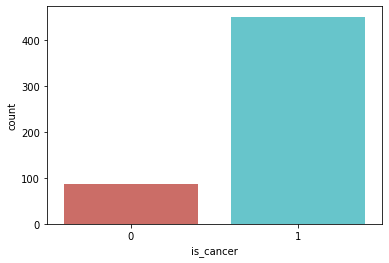

In [16]:
sns.countplot(x='is_cancer', data=df_sorted, palette='hls')
plt.show()
# plt.savefig('count_iscancer_plot')

In [ ]:
count_nocancer = len(t2wDF_PZ_fo_LDF[t2wDF_PZ_fo_LDF['is_cancer']==0])
count_cancer = len(t2wDF_PZ_fo_LDF[t2wDF_PZ_fo_LDF['is_cancer']==1])
pct_nocancer = count_nocancer/(count_nocancer + count_cancer)
print('percentage of healthy subjects: ', pct_nocancer)
pct_cancer = count_cancer/(count_nocancer + count_cancer)
print('percentage of subjects with cancer: ', pct_cancer)

# Our classes are imbalanced, and the ratio of subjects with cancer to healthy subjects is 84:16.

percentage of healthy subjects:  0.16420664206642066
percentage of subjects with cancer:  0.8357933579335793


In [ ]:
temp = t2wDF_PZ_fo_LDF.groupby('is_cancer').mean()
#temp.drop('patient_id', axis=1)

In [ ]:
temp = t2wDF_PZ_fo_LDF.groupby('is_cancer').median()
#temp.drop('patient_id', axis=1)

In [ ]:
t2wDF_PZ_fo_LDF

In [ ]:
# Balancing the data - Over-sampling using SMOTE

X = t2wDF_PZ_fo_LDF.loc[:, t2wDF_PZ_fo_LDF.columns != 'is_cancer']
y = t2wDF_PZ_fo_LDF.loc[:, t2wDF_PZ_fo_LDF.columns == 'is_cancer']

from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['is_cancer'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['is_cancer']==0]))
print("Number of subscription",len(os_data_y[os_data_y['is_cancer']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['is_cancer']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['is_cancer']==1])/len(os_data_X))

length of oversampled data is  646
Number of no subscription in oversampled data 323
Number of subscription 323
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [ ]:
# Recursive Feature Elimination

t2wDF_PZ_fo_LDF_vars=t2wDF_PZ_fo_LDF.columns.values.tolist()
y=['is_cancer']
X=[i for i in t2wDF_PZ_fo_LDF_vars if i not in y]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, step = 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[False  True  True False False False  True False  True  True False  True
 False  True False  True False  True]
[2 1 1 2 2 2 1 2 1 1 2 1 2 1 2 1 2 1]


In [ ]:
list(np.ravel(np.where(rfe.support_==True)))

[1, 2, 6, 8, 9, 11, 13, 15, 17]

In [ ]:
# Features selected by RFE
X = os_data_X.iloc[:, np.ravel(np.where(rfe.support_==True))]
y=os_data_y['is_cancer']

In [ ]:
# Implementing the model

import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

NameError: ignored

In [ ]:
# The p-values (P>|z|) for most of the variables are smaller than 0.05, except five variables, therefore, we will remove them.


X=os_data_X.iloc[:, np.ravel(np.where(result.pvalues<0.05))]
y=os_data_y['is_cancer']
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.687286
         Iterations 4
                                     Results: Logit
Model:                        Logit                    Pseudo R-squared:         0.008   
Dependent Variable:           is_cancer                AIC:                      895.9735
Date:                         2023-03-06 11:10         BIC:                      913.8567
No. Observations:             646                      Log-Likelihood:           -443.99 
Df Model:                     3                        LL-Null:                  -447.77 
Df Residuals:                 642                      LLR p-value:              0.055721
Converged:                    1.0000                   Scale:                    1.0000  
No. Iterations:               4.0000                                                     
-----------------------------------------------------------------------------------------
                                    

In [ ]:
# Logistic Regression Model Fitting

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.80


In [ ]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
# The result is telling us that we have 0 + 130 correct predictions and 0 + 33 incorrect predictions.
# True positive (TP)  -  False negative (FN)
# False positive (FP)  -  True negative (TN)

[[  0  33]
 [  0 130]]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.80      1.00      0.89       130

    accuracy                           0.80       163
   macro avg       0.40      0.50      0.44       163
weighted avg       0.64      0.80      0.71       163



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


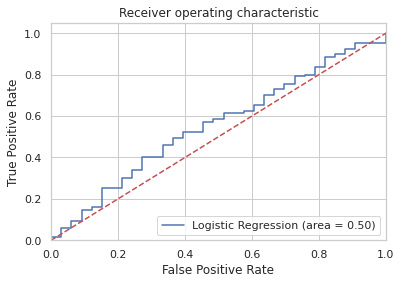

In [ ]:
# ROC Curve

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## **Logistic regression without balancing of the data**

In [ ]:
# Not balanced data 

X = t2wDF_PZ_fo_LDF.loc[:, t2wDF_PZ_fo_LDF.columns != 'is_cancer']
y = t2wDF_PZ_fo_LDF.loc[:, t2wDF_PZ_fo_LDF.columns == 'is_cancer']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
y_train.count(y_train.value_counts==1)

is_cancer    433
dtype: int64

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(433, 18) (109, 18) (433, 1) (109, 1)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

model = LogisticRegression(max_iter=5000, solver='saga')
model.fit(X_train, np.ravel(y_train))

LogisticRegression(max_iter=5000, solver='saga')

In [ ]:
model.classes_

array([0, 1])

In [ ]:
model.predict(X_train)
model.score(X_train, np.ravel(y_train))

0.8429561200923787

In [ ]:
y_pred = model.predict(X_test)
model.score(X_test, np.ravel(y_test))

0.8073394495412844

In [ ]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[ 0 21]
 [ 0 88]]


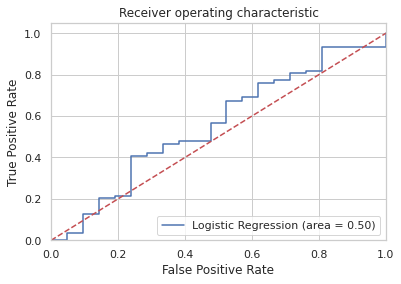

In [ ]:
# ROC Curve

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()